In [ ]:
import numpy as np #linear algebra
import pandas as pd # data processing, .csv load
import os

#Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#Data Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import itertools #For Confusion Matrix
%matplotlib inline
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Scaling
from sklearn import preprocessing #For data normalization

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV # For parameterization and splitting data
from sklearn.metrics import confusion_matrix
from sklearn import metrics # For Accuracy
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
cancer=pd.read_csv('/content/drive/MyDrive/Breast_cancer_data.csv')

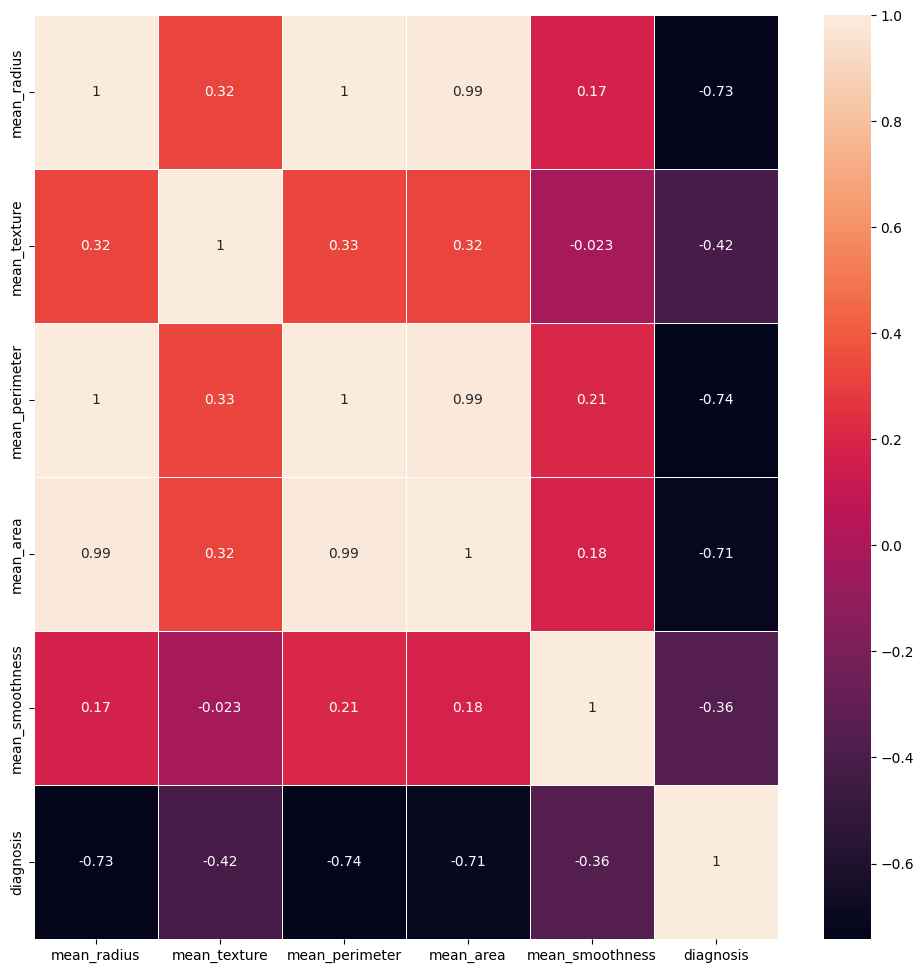

In [ ]:
x, ax=plt.subplots(figsize=(12,12))
sns.heatmap(cancer.corr(),annot=True, linewidths=0.5, ax=ax)
plt.show()

In [ ]:
cancer_corr = cancer.corr()
corr_target = abs(cancer_corr["diagnosis"])
relevant_features = corr_target[corr_target>0.5]
relevant_features

mean_radius       0.730029
mean_perimeter    0.742636
mean_area         0.708984
diagnosis         1.000000
Name: diagnosis, dtype: float64

In [ ]:
X_feat=cancer[['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness']]
y_feat=cancer['diagnosis']
X_feat

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
0,17.99,10.38,122.80,1001.0,0.11840
1,20.57,17.77,132.90,1326.0,0.08474
2,19.69,21.25,130.00,1203.0,0.10960
3,11.42,20.38,77.58,386.1,0.14250
4,20.29,14.34,135.10,1297.0,0.10030
...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100
565,20.13,28.25,131.20,1261.0,0.09780
566,16.60,28.08,108.30,858.1,0.08455
567,20.60,29.33,140.10,1265.0,0.11780


In [ ]:
bestfeatures = SelectKBest(score_func=f_classif, k=5)
fit = bestfeatures.fit(X_feat,y_feat)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_feat.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Assembly','Score']  #naming the dataframe columns
print(featureScores.nlargest(12,'Score'))

          Assembly       Score
2   mean_perimeter  697.235272
0      mean_radius  646.981021
3        mean_area  573.060747
1     mean_texture  118.096059
4  mean_smoothness   83.651123


In [ ]:
train_accuracy= []
accuracy_list = []
algorithm = []

X_train,X_test,y_train,y_test = train_test_split(cancer[['mean_perimeter','mean_radius','mean_area']]
                                                 ,cancer['diagnosis'],test_size=0.2, random_state=0)
print("X_train shape :",X_train.shape)
print("Y_train shape :",y_train.shape)
print("X_test shape :",X_test.shape)
print("Y_test shape :",y_test.shape)

X_train shape : (455, 3)
Y_train shape : (455,)
X_test shape : (114, 3)
Y_test shape : (114,)


In [ ]:
scaler_ss=preprocessing.StandardScaler()
X_train_scaled=scaler_ss.fit_transform(X_train)
X_test_scaled=scaler_ss.transform(X_test)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.BuGn):

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



The best parameters are  {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'max_features': None, 'n_estimators': 10, 'random_state': None}
Train Accuracy 0.916
Test Accuracy0.895
[[38  9]
 [ 3 64]]


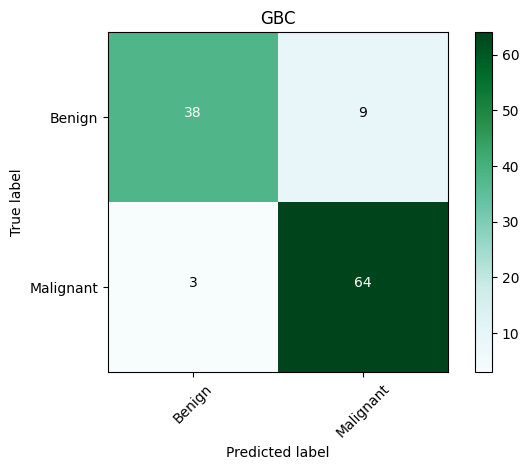

In [ ]:
GBC_parma={'loss':['log_loss','exponential'],'n_estimators':[10,25,50,100,150],'learning_rate':[0.1,0.25, 0.5, 0.75],
          'criterion':['friedman_mse'], 'max_features':[None],'max_depth':[1,2,3,4,5,10],'random_state':[None]}
GBC = GradientBoostingClassifier()
GBC_parm=GridSearchCV(GBC, GBC_parma, cv=5)
GBC_parm.fit(X_train_scaled, y_train)
y_GBC=GBC_parm.predict(X_test_scaled)
print("The best parameters are ",GBC_parm.best_params_)
print("Train Accuracy {0:.3f}".format(GBC_parm.score(X_train_scaled, y_train)))
print('Test Accuracy' "{0:.3f}".format(metrics.accuracy_score(y_test, y_GBC)))
cm = metrics.confusion_matrix(y_test, y_GBC)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=['Benign', 'Malignant'],
                          title='GBC')
train_accuracy.append(GBC_parm.score(X_train_scaled, y_train))
accuracy_list.append(metrics.accuracy_score(y_test, y_GBC)*100)
algorithm.append('GBC')